In [21]:
import pandas as pd 
import numpy as np
import sklearn 
from sklearn.metrics import mean_squared_error
import prophet
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
import matplotlib.pyplot as plt 
from pmdarima.arima.utils import ndiffs  

In [22]:
#  подгружаю данные (взял базу данных из примера по которому делал)
df = pd.read_csv('Electric_Production.csv',parse_dates=['DATE'], index_col=['DATE'])


In [26]:
df.head()

,value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


In [23]:
ts = df['value'].resample('MS').sum()


In [24]:
ts.head()

DATE
1985-01-01    72.5052
1985-02-01    70.6720
1985-03-01    62.4502
1985-04-01    57.4714
1985-05-01    55.3151
Freq: MS, Name: value, dtype: float64

<Axes: xlabel='DATE'>

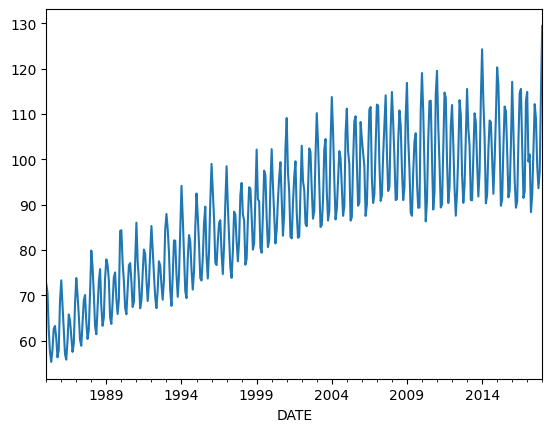

In [25]:
# Отображаю временной ряд
ts.plot()

In [36]:
len(ts)

397

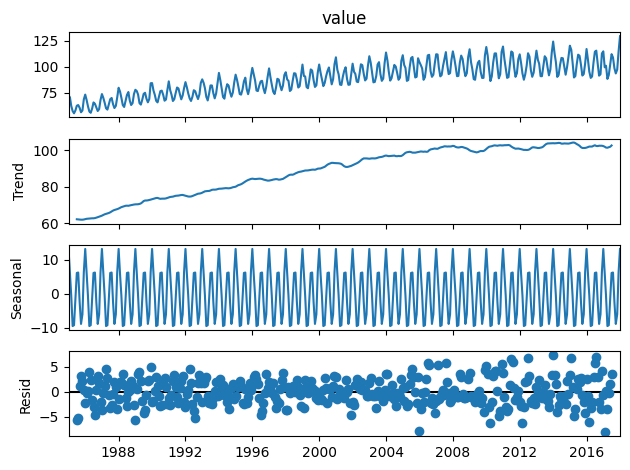

In [26]:
decomposition = sm.tsa.seasonal_decompose(ts,model = 'additive')
fig = decomposition.plot()
plt.show()

In [27]:
adftest = adfuller(ts)

In [28]:
print('pvvalue from adftest:',adftest[1])

pvvalue from adftest: 0.1862146911658738


In [29]:
# Разбиваю датасет на train и test
train_ts = ts[:300]
test_ts = ts [301:]

In [54]:
# Создаю модель ARIMA order взял из расчета ниже
model = ARIMA(train_ts, order=(5,0,3)).fit()

In [55]:
# Рассчитываю предикт
pred = model.predict(start=len(train_ts),end=(len(ts)-2))

<Axes: xlabel='DATE'>

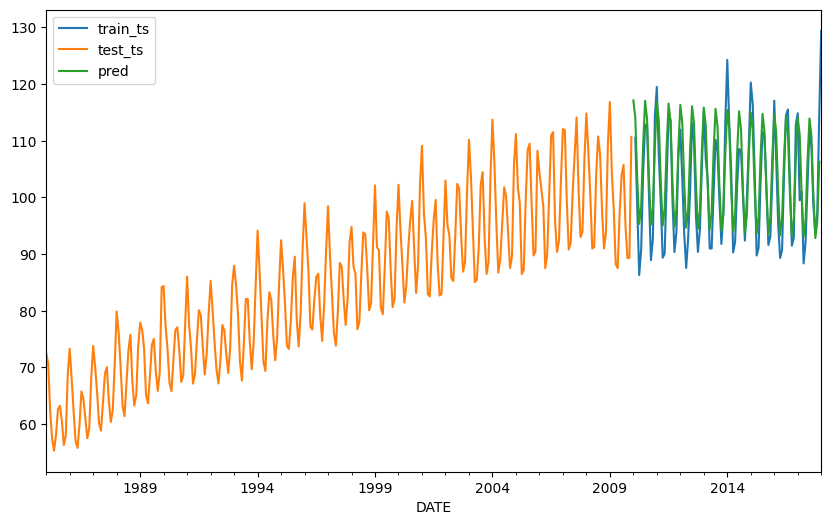

In [56]:
# Вывожу графики
test_ts.plot(legend=True, label = 'train_ts', figsize=(10,6))
train_ts.plot(legend=True, label = 'test_ts')
pred.plot(legend=True, label = 'pred')

In [31]:
print(len(test_ts))
print(len(pred))

96
96


In [33]:
error = np.sqrt(mean_squared_error(test_ts,pred))
error

9.797626320541294

In [33]:
# Начинаю подбор параметров для модели ARIMA 
import itertools
import warnings
warnings.filterwarnings('ignore')

In [60]:
p = range(0,8)
q = range(0,8)
d = range(0,4)

In [61]:
pqd_combination = list(itertools.product(p,q,d))
rmse = []
order1 = []


In [65]:
for pqd in pqd_combination:
        model = ARIMA(train_ts,order=pqd)
        model.initialize_approximate_diffuse() # this line
        trained = model.fit()
        pred = trained.predict(start=len(train_ts),end=(len(ts)-2))
        error = np.sqrt(mean_squared_error(test_ts,pred))
        order1.append(pqd)
        rmse.append(error)
        # print('PQD_', pqd)
    

In [37]:
rmse

[20.510887005360566,
 20.29981741622361,
 12.751151228455313,
 22.998425778356236,
 1198.0314955802755,
 1457.7985101714091,
 46129.39481138275,
 1358.5863399722766,
 964352.4038814662,
 51548.93272508438,
 20693364.610288505,
 991837.3983459141,
 795842845.9284611,
 22597511.606144127,
 28880046610.590134,
 836418827.5795436,
 19.16156558643312,
 19.604816445024305,
 22.76140794777756,
 24.044635626229837,
 1384.6018851291287,
 1385.9602973916074,
 40104.412595752976,
 1566.3224420234453,
 648455.7373691435,
 44719.486214555756,
 2819596.2626692276,
 667849.2665225363,
 13001306.861168165,
 3345624.3141697287,
 2965117557.3358026,
 17083920.67969361,
 20.057153989830038,
 19.92725664064513,
 12.002292723722416,
 9.582273363269882,
 918.7826426830233,
 17.46270061169194,
 35596.90561791707,
 1049.6810510902878,
 669803.1203636876,
 39619.95068398943,
 5585478.8006986845,
 694815.8523512095,
 14485988.56889679,
 6216800.7420016145,
 652007537.5100359,
 17202535.59938797,
 18.04214044309

In [66]:
results = pd.DataFrame(index=order1, data=rmse, columns=["RMSE"])

In [67]:
str = results[results['RMSE']==results['RMSE'].min()]

In [68]:
# Вывожу лучший параметр
str

,RMSE
"(6, 1, 3)",8.720122


In [39]:
results.to_csv('ARIMA_Results.csv')